# Sharpe Ratio  

The Sharpe ratio, developed by Nobel laureate William F. Sharpe, is a widely used measure for calculating risk-adjusted return and has become the industry standard for such assessments. It quantifies the average return earned in excess of the risk-free rate per unit of volatility (or total risk). By subtracting the risk-free rate from the mean return, the Sharpe ratio isolates the performance specifically associated with risk-taking activities.  A portfolio with a Sharpe ratio of zero indicates a "zero-risk" investment, like holding U.S. Treasury bills, as its expected return would be equivalent to the risk-free rate.  Generally, the higher the Sharpe ratio, the more attractive the risk-adjusted return, signifying a better reward for the level of risk taken.

In [27]:
# Import the required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Set defaults for high resolution displays
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (10, 6)
plt.style.use("default")

### Functions to fetch data from Yahoo Finance

In [28]:
def fetch_yahoo_data(tickers, start_date, end_date):
    """Fetches financial data from Yahoo Finance."""
    df = yf.download(tickers, start=start_date, end=end_date)
    df = df.ffill().resample("D").ffill()
    df.columns = ["_".join(col).strip() for col in df.columns.values]
    return df


def clean_data(df):
    """Cleans the data by dropping unnecessary columns."""
    df = df.drop(
        columns=[col for col in df.columns if "Close" in col and "Adj" not in col]
    )
    if "Volume_DX-Y.NYB" in df.columns:
        df = df.drop(columns=["Volume_DX-Y.NYB"])
    return df


def create_column_mapping(tickers):
    """Creates a mapping for column renaming."""
    column_mapping = {}
    asset_names = {
        "COIN": "coinbase",
        "BTC-USD": "bitcoin",
        "ETH-USD": "ethereum",
        "GC=F": "gold",
        "DX-Y.NYB": "us_dollar_index",
    }
    columns = ["Adj Close", "High", "Low", "Open", "Volume"]

    for ticker in tickers:
        asset = asset_names.get(ticker, ticker)
        for col in columns:
            old_col = f"{col}_{ticker}"
            if col == "Adj Close":
                new_col = f"{asset}_price"
            else:
                new_col = f"{asset}_{col.lower().replace(' ', '_')}"
            column_mapping[old_col] = new_col

    return column_mapping


def rename_columns(df, column_mapping):
    """Renames the columns based on the provided mapping."""
    return df.rename(columns=column_mapping)


def calculate_returns(df):
    """Calculates daily returns for specific assets."""
    assets = ["bitcoin", "coinbase", "ethereum", "gold"]

    for asset in assets:
        price_col = f"{asset}_price"
        if price_col in df.columns:
            # Calculate simple returns
            df[f"{asset}_return"] = df[price_col].pct_change()
            # Calculate log returns
            df[f"{asset}_log_return"] = np.log(df[price_col] / df[price_col].shift(1))
        else:
            print(
                f"Warning: {price_col} not found in dataframe. Skipping return calculation."
            )
    return df


def order_columns(df):
    """Orders the columns with key columns at the front."""
    key_columns = ["coinbase_price", "bitcoin_price", "ethereum_price"]
    remaining_columns = [col for col in df.columns if col not in key_columns]
    return df[key_columns + remaining_columns]


def fetch_and_process_financial_data(tickers, start_date, end_date):
    """Main function to fetch and process financial data."""
    df = fetch_yahoo_data(tickers, start_date, end_date)
    df = clean_data(df)
    column_mapping = create_column_mapping(tickers)
    df = rename_columns(df, column_mapping)
    df = calculate_returns(df)
    df = order_columns(df)
    return df

In [29]:
# Fetch Coinbase, Bitcoin, and Ethereum data from Yahoo Finance
tickers = ["COIN", "BTC-USD", "ETH-USD"]
start_date = "2021-04-14"
end_date = datetime.today().strftime("%Y-%m-%d")
df = fetch_and_process_financial_data(tickers, start_date, end_date)
df.head()

[*********************100%%**********************]  3 of 3 completed

,coinbase_price,bitcoin_price,ethereum_price,bitcoin_high,coinbase_high,ethereum_high,bitcoin_low,coinbase_low,ethereum_low,bitcoin_open,...,ethereum_open,bitcoin_volume,coinbase_volume,ethereum_volume,bitcoin_return,bitcoin_log_return,coinbase_return,coinbase_log_return,ethereum_return,ethereum_log_return
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-14,328.279999,63109.695312,2435.104980,64863.097656,429.540009,2449.687500,61554.796875,310.000000,2284.563721,63523.753906,...,2299.347900,77451779687,81065700.0,35592822986,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-15,322.750000,63314.011719,2519.116211,63821.671875,349.200012,2544.267334,62208.964844,317.269989,2409.924072,63075.195312,...,2436.034668,60954381579,39777900.0,32325606817,0.003237,0.003232,-0.016845,-0.016989,0.034500,0.033918
2021-04-16,342.000000,61572.789062,2431.946533,63594.722656,345.989990,2547.555664,60222.531250,321.029999,2318.675049,63258.503906,...,2516.601807,84293007468,22654500.0,36196928256,-0.027501,-0.027887,0.059644,0.057933,-0.034603,-0.035216
2021-04-17,342.000000,60683.820312,2344.895020,62572.175781,345.989990,2497.385254,60361.351562,321.029999,2333.682861,61529.921875,...,2429.980957,66138759198,22654500.0,32349808978,-0.014438,-0.014543,0.000000,0.000000,-0.035795,-0.036451
2021-04-18,342.000000,56216.183594,2237.136963,61057.457031,345.989990,2365.460449,52829.535156,321.029999,2011.766846,60701.886719,...,2346.452393,97468872758,22654500.0,50696368718,-0.073622,-0.076472,0.000000,0.000000,-0.045954,-0.047044


### Filtering the data to get the required columns

In [30]:
# Slice dataframe to only log returns
df_log_returns = df.filter(like="log_return")
df_log_returns = df_log_returns.dropna()
df_log_returns.head()

,bitcoin_log_return,coinbase_log_return,ethereum_log_return
Date,,,
2021-04-15,0.003232,-0.016989,0.033918
2021-04-16,-0.027887,0.057933,-0.035216
2021-04-17,-0.014543,0.000000,-0.036451
2021-04-18,-0.076472,0.000000,-0.047044
2021-04-19,-0.008789,-0.026668,-0.032228


In [31]:
# LSTM Predictions
btc_pred_returns = pd.read_csv("lstm_data/btc_usd_future_predictions_lstm.csv")
coin_pred_returns = pd.read_csv("lstm_data/coin_future_predictions_lstm.csv")
eth_pred_returns = pd.read_csv("lstm_data/eth_usd_future_predictions_lstm.csv")

btc_pred_returns.columns = ["date", "bitcoin_log_return"]
coin_pred_returns.columns = ["date", "coinbase_log_return"]
eth_pred_returns.columns = ["date", "ethereum_log_return"]

btc_pred_returns = btc_pred_returns.drop(columns=["date"])
eth_pred_returns = eth_pred_returns.drop(columns=["date"])

lstm_df = pd.concat([coin_pred_returns, btc_pred_returns, eth_pred_returns], axis=1)

# Convert the log return columns to float
lstm_df["coinbase_log_return"] = lstm_df["coinbase_log_return"].str.extract(r'\[([^\]]+)\]').astype(float)
lstm_df["bitcoin_log_return"] = lstm_df["bitcoin_log_return"].str.extract(r'\[([^\]]+)\]').astype(float)
lstm_df["ethereum_log_return"] = lstm_df["ethereum_log_return"].str.extract(r'\[([^\]]+)\]').astype(float)

lstm_df.head()

,date,coinbase_log_return,bitcoin_log_return,ethereum_log_return
0,2024-06-28,-0.035629,0.031294,0.022280
1,2024-07-01,0.026017,0.014438,0.112775
2,2024-07-02,-0.092055,-0.136956,-0.140241
3,2024-07-03,0.026096,-0.072088,-0.035320
4,2024-07-04,0.059044,-0.075198,-0.062062


In [50]:
# Read the CSV files for ARIMAX predictions
btc_pred_returns_arimax = pd.read_csv("arimax_data/btc_usd_future_predictions.csv")
coin_pred_returns_arimax = pd.read_csv("arimax_data/coin_usd_future_predictions.csv")
eth_pred_returns_arimax = pd.read_csv("arimax_data/eth_usd_future_predictions.csv")

# Rename the columns
btc_pred_returns_arimax.columns = ["date", "bitcoin_log_return"]
coin_pred_returns_arimax.columns = ["date", "coinbase_log_return"]
eth_pred_returns_arimax.columns = ["date", "ethereum_log_return"]

# Drop the 'date' column from the correct DataFrames
btc_pred_returns_arimax = btc_pred_returns_arimax.drop(columns=["date"])
eth_pred_returns_arimax = eth_pred_returns_arimax.drop(columns=["date"])

# Concat the ARIMAX predictions
arimax_df = pd.concat([coin_pred_returns_arimax, btc_pred_returns_arimax, eth_pred_returns_arimax], axis=1)

arimax_df.head()

,date,coinbase_log_return,bitcoin_log_return,ethereum_log_return
0,2024-06-27,0.012453,0.012202,0.017261
1,2024-06-28,0.039434,-0.016790,-0.028488
2,2024-07-01,0.020531,0.008828,0.010994
3,2024-07-02,0.026030,0.002913,0.041289
4,2024-07-03,-0.033320,0.005839,-0.000544


### Sharpe Ratio Analysis

In [32]:
def compute_single_sharpe_ratio(returns, risk_free_rate=0, trading_days=252):
    """Computes the Sharpe ratio for a single asset."""
    returns = pd.to_numeric(returns, errors="coerce")
    excess_returns = returns - risk_free_rate
    return np.sqrt(trading_days) * excess_returns.mean() / excess_returns.std()


def compute_multiple_sharpe_ratios(df_log_returns, annual_risk_free_rate=0.05):
    """Computes Sharpe ratios for multiple assets."""
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1 / 365) - 1

    sharpe_ratios = {}
    assets = {
        "COIN": ("coinbase_log_return", 252),
        "BTC": ("bitcoin_log_return", 365),
        "ETH": ("ethereum_log_return", 365),
    }

    for ticker, (column, trading_days) in assets.items():
        sharpe_ratios[ticker] = compute_single_sharpe_ratio(
            df_log_returns[column], daily_risk_free_rate, trading_days
        )

    return sharpe_ratios

In [33]:
# Compute Sharpe ratios
lstm_sharpe_ratios = compute_multiple_sharpe_ratios(lstm_df)

# Display results
print(lstm_sharpe_ratios)

{'COIN': 26.963320064171448, 'BTC': 19.009253182282908, 'ETH': 27.84427927565101}


In [51]:
arimax_sharpe_ratios = compute_multiple_sharpe_ratios(arimax_df)

# Display results
print(arimax_sharpe_ratios)

{'COIN': 1.3459029434525942, 'BTC': 1.0162496617917542, 'ETH': 0.7908522710372899}


### Visual Representation of Sharpe Ratios and Log Returns (LSTM)

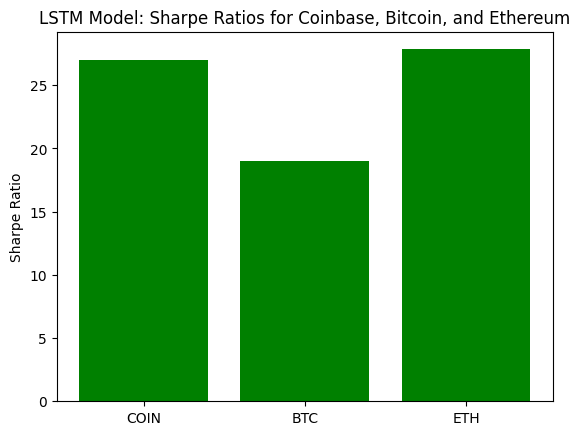

In [34]:
# Add red and green colors based on the Sharpe ratio value
plt.bar(lstm_sharpe_ratios.keys(), lstm_sharpe_ratios.values(), color=["red" if x < 0 else "green" for x in lstm_sharpe_ratios.values()])
plt.ylabel("Sharpe Ratio")
plt.title("LSTM Model: Sharpe Ratios for Coinbase, Bitcoin, and Ethereum")
plt.show()

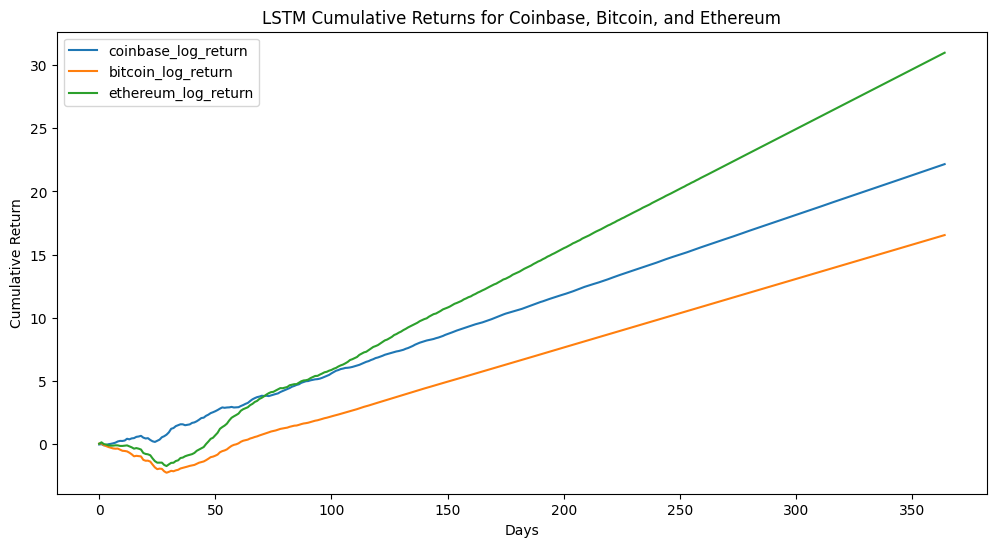

In [41]:
# Plot the cumulative returns
df_cum_returns = lstm_df.filter(like="log_return").dropna().cumsum()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cum_returns, dashes=False)
plt.title("LSTM Cumulative Returns for Coinbase, Bitcoin, and Ethereum")
plt.ylabel("Cumulative Return")
plt.xlabel("Days")
plt.show()

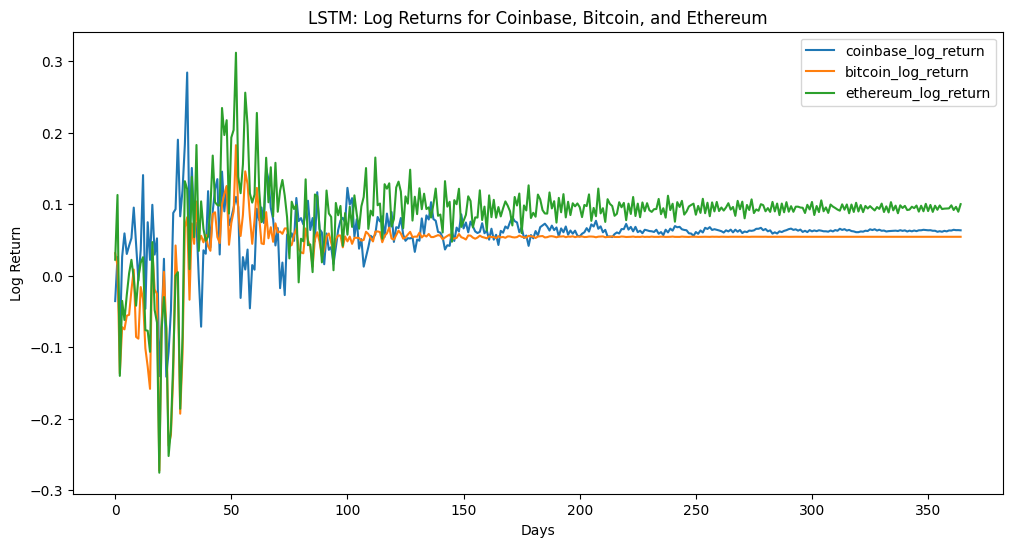

In [57]:
# Plot the log returns
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=lstm_df, dashes=False)
plt.title("LSTM: Log Returns for Coinbase, Bitcoin, and Ethereum")
plt.ylabel("Log Return")
plt.xlabel("Days")
plt.show()

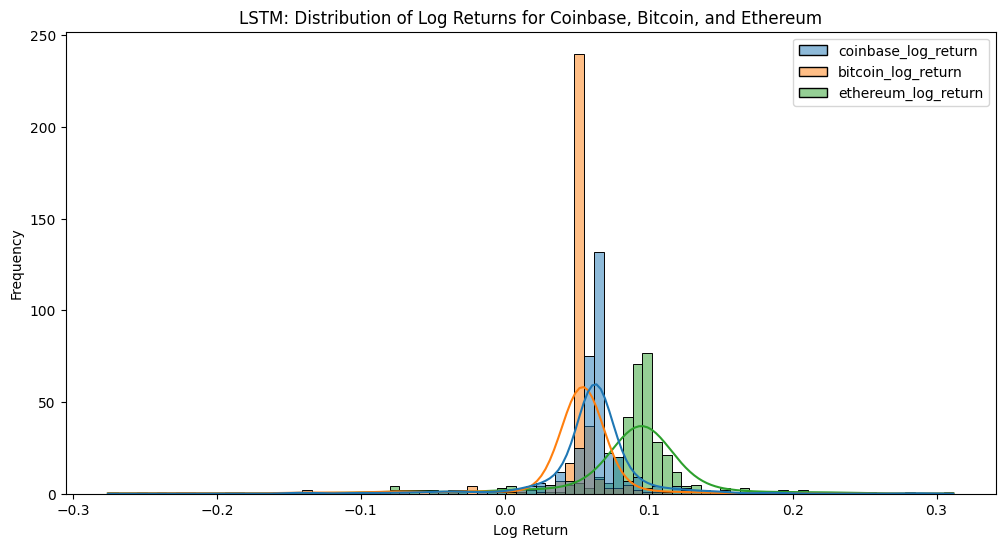

In [40]:
# Plot the distribution of log returns
plt.figure(figsize=(12, 6))
sns.histplot(data=lstm_df, kde=True)
plt.title("LSTM: Distribution of Log Returns for Coinbase, Bitcoin, and Ethereum")
plt.ylabel("Frequency")
plt.xlabel("Log Return")
plt.show()

### Visual Representation of Sharpe Ratios and Log Returns (Arimax)

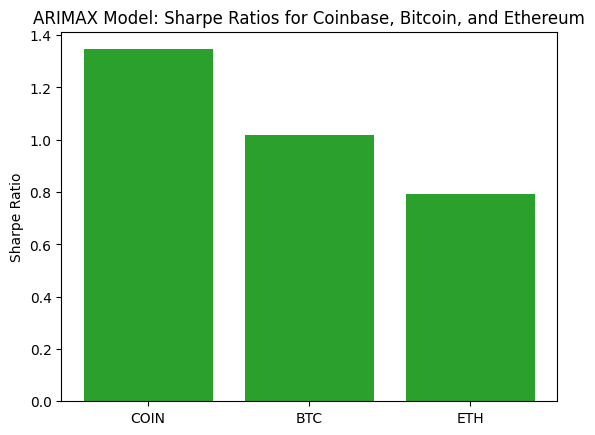

In [60]:
# Add red and green colors based on the Sharpe ratio value
plt.bar(arimax_sharpe_ratios.keys(), arimax_sharpe_ratios.values(), color=["tab:red" if x < 0 else "tab:green" for x in arimax_sharpe_ratios.values()])
plt.ylabel("Sharpe Ratio")
plt.title("ARIMAX Model: Sharpe Ratios for Coinbase, Bitcoin, and Ethereum")
plt.show()

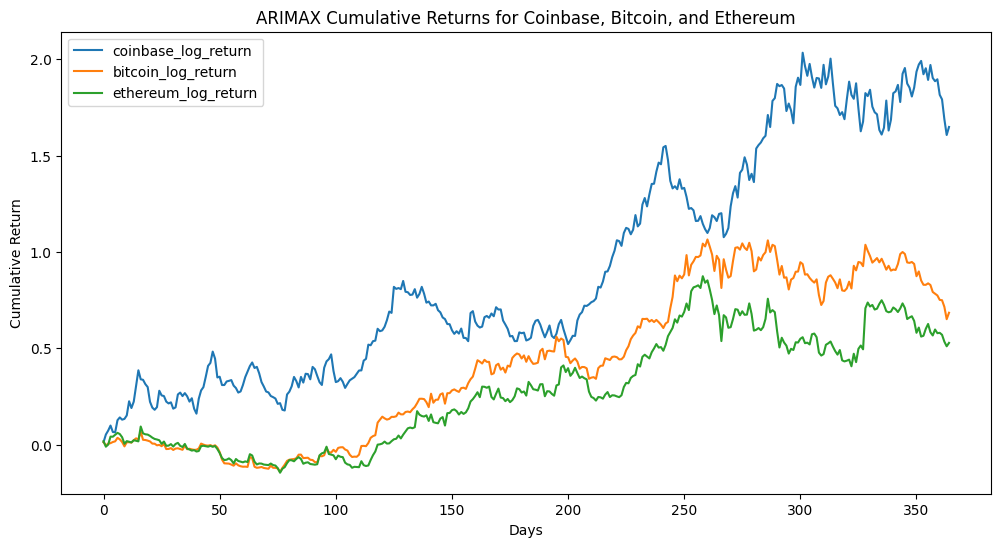

In [54]:
# Plot the cumulative returns
df_cum_returns = arimax_df.filter(like="log_return").dropna().cumsum()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cum_returns, dashes=False)
plt.title("ARIMAX Cumulative Returns for Coinbase, Bitcoin, and Ethereum")
plt.ylabel("Cumulative Return")
plt.xlabel("Days")
plt.show()

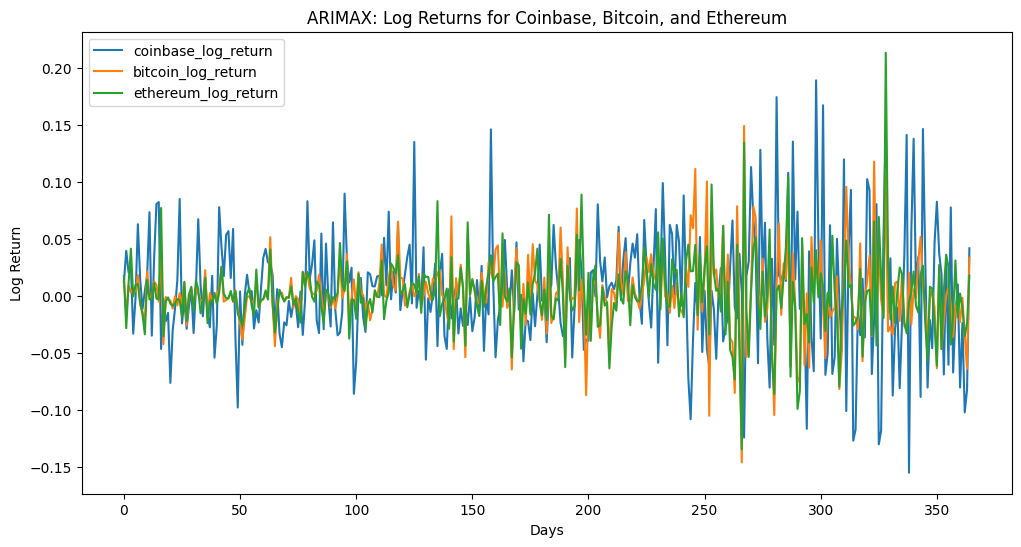

In [56]:
# Plot the log returns
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=arimax_df, dashes=False)
plt.title("ARIMAX: Log Returns for Coinbase, Bitcoin, and Ethereum")
plt.ylabel("Log Return")
plt.xlabel("Days")
plt.show()

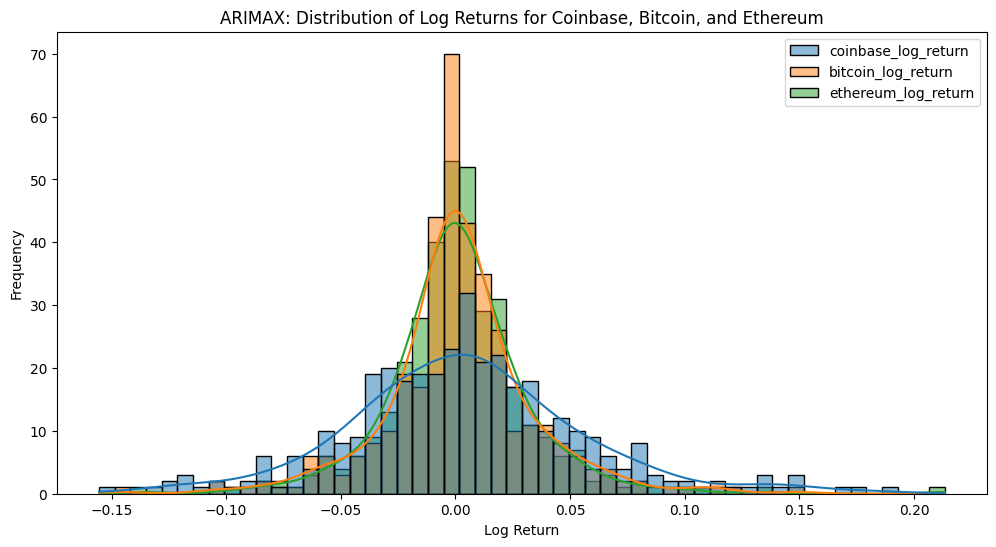

In [58]:
# Plot the distribution of log returns
plt.figure(figsize=(12, 6))
sns.histplot(data=arimax_df, kde=True)
plt.title("ARIMAX: Distribution of Log Returns for Coinbase, Bitcoin, and Ethereum")
plt.ylabel("Frequency")
plt.xlabel("Log Return")
plt.show()